In [46]:
import matplotlib.pyplot as plt
import sys
import math

sys.path.append('../../')
# from column import Column

from porousmedialab.column import Column

import numpy as np

%matplotlib inline
# %matplotlib notebook

from thawmeasurements import  Vh2, Vh3, C2h, C3h, C3D33, C2D33, C3D21, C2D21, C3D9, C2D9, Tm_nz, C1h_nz, F3Tm, F3T_frz, T3Tm, T2T_thw, F2Tm, F2T_frz, T1T_thw, T2Tm, F1T_frz, T1Tm, C1h, T1C1h, F1C1h, T2C1h, F2C1h, T3C1h, F3C1h, C1D9, T1C1D9, T2C1D9, T3C1D9, C1D21, T1C1D21, F1C1D21, T2C1D21, F2C1D21, T3C1D21, F3C1D21, C1D33, T1C1D33, F1C1D33, T2C1D33, F2C1D33, T3C1D33, F3C1D33, Tm, T1Tm, F1Tm, T2Tm, F2Tm, T3Tm, F3Tm, zm, D_SF6w, D_SF6g, Kh, phi_m, z_phi, Vh1, SA, D_column, Vi, Ci, T1Ci, F1Ci, T2Ci, F2Ci, T3Ci, F3Ci, Ti, T1Ti, F1Ti, T2Ti, F2Ti, T3Ti, F3Ti, SF6_Hcc, T_frz, T_thw

import seaborn as sns
                                                                                                                                                                                                                    
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 32})
sns.set_context("poster", rc={"font.size":34,"axes.titlesize":34,"axes.labelsize":34, "lines.linewidth": 4, 'lines.markersize':10})  
plt.rcParams['figure.figsize'] = 8, 6


In [47]:
# from porousmedialab.calibrator import find_indexes_of_intersections
# from porousmedialab.metrics import rmse

In [48]:
Tm = np.concatenate([0 + T1Tm, F1T_frz+F1Tm, T1T_thw+T2Tm, F2T_frz+F2Tm, T2T_thw+T3Tm, F3T_frz+F3Tm])
Ti = np.array(np.array([16, 177, 350, 514, 681, 851]))
t_shift = Ti[0]
Tm = Tm-t_shift
Ti_1 = Ti-t_shift

In [49]:
w, k_w_in, k_w_out, k_g_in, k_g_out =[-0.0146734865079, 0.0384866051036, 0.023407578148, 0.14239721947, 54.5771637419] #100h x100
w, k_w_in, k_w_out, k_g_in, k_g_out =[-0.0161538153432, 0.0410897302904, 0.0222350321705, 0.146847335254, 40.7793911951]

In [50]:
periods = np.concatenate([T_frz, T_thw])
periods.sort()
periods = periods - t_shift
periods

array([114, 306, 457, 596, 796, 944])

In [51]:
tend = periods[0]
# tend = 457
dt = 0.01
dx = 0.2 ## cm
L = 40 ## cm
x = np.linspace(0, L, L / dx + 1)
t = np.linspace(0, tend, round(tend / dt) + 1)
#phi = 0.8
Chs = np.zeros(t.shape) #
Fx = np.zeros(t.shape)


/Users/imarkelo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  
/Users/imarkelo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  import sys


In [52]:
dT = Tm_nz[1::2] - Tm_nz[::2]

dC1h = (C1h_nz[1::2] - C1h_nz[::2])


Mi = T1Ci*Vi # mass injected

#h_inj = Vi/SA/phi
h_inj = Vi/SA/0.93

In [53]:
ftc1 = Column(L, dx, tend, dt)

In [54]:
#Pores from the FTR experiment#

phi_w = phi*(0.875/0.97)
phi_g = 1 - phi
phi_p = phi*((0.97-0.875)/0.97) 

# conversion factor from water to gas
F_wg = phi_w/phi_g
# conversion factor from water to pore space
F_wp = phi_w/phi_p



In [55]:
ftc1.add_species(theta=((phi_g**(10/3))/(phi**2)), element='SF6g', D= D_SF6g, init_C=0, bc_top=0, bc_top_type='constant', bc_bot=0, bc_bot_type='constant', w = -0.00)  #-0.055
ftc1.add_species(theta=((phi_w**(10/3))/(phi**2)), element='SF6w', D= D_SF6w, init_C=0, bc_top=0, bc_top_type='constant', bc_bot=0, bc_bot_type='constant', w = w)

# SF6mp stands for SF6 gas in micro pores, it is immobile and only collects SF6;
ftc1.add_species(theta=phi_p, element='SF6mp', D=1e-18, init_C=0, bc_top=0, bc_top_type='flux', bc_bot=0, bc_bot_type='flux')


# # Constants
ftc1.constants['k_w_in'] =  k_w_in #from FTR w
ftc1.constants['k_w_out'] = k_w_out
#0.4

ftc1.constants['k_g_in'] = k_g_in
ftc1.constants['k_g_out'] = k_g_out

ftc1.constants['phi_w'] = phi_w
ftc1.constants['phi_g'] = phi_g
ftc1.constants['phi_p'] = phi_p


# # Rates of diffusion into pores and out
ftc1.rates['R_w_in'] = 'k_w_in * SF6w'
ftc1.rates['R_w_out'] = 'k_w_out * SF6mp'
# ftc1.rates['R_w_in'] = '0'
# ftc1.rates['R_w_out'] = '0'

ftc1.rates['R_g_in'] = 'k_g_in * SF6w'
ftc1.rates['R_g_out'] = 'k_g_out * SF6g'

# # dcdt
ftc1.dcdt['SF6w'] = '-R_g_in + R_g_out * phi_g - R_w_in + R_w_out * phi_p'
ftc1.dcdt['SF6g'] = 'R_g_in / phi_g - R_g_out'
ftc1.dcdt['SF6mp'] = 'R_w_in / phi_p - R_w_out'




In [56]:
Fx = np.zeros(t.size)

In [57]:
# %pdb

In [58]:
for i in range(0, len(ftc1.time)):
    if (ftc1.time[i] > periods[0] and ftc1.time[i] < periods[1]) or (
            ftc1.time[i] > periods[2] and ftc1.time[i] < periods[3]
    ) or (ftc1.time[i] > periods[4] and ftc1.time[i] < periods[5]):
        ftc1.change_boundary_conditions('SF6g', i, bc_top=0, bc_top_type='flux')
        ftc1.change_boundary_conditions('SF6w', i, bc_top=0, bc_top_type='flux')
        Fx[i] = 0
    else:
        ftc1.change_boundary_conditions('SF6g', i, bc_top=0, bc_top_type='constant')
        ftc1.change_boundary_conditions('SF6w', i, bc_top=0, bc_top_type='constant')
        F1 = ftc1.estimate_flux_at_top('SF6g', i)
        F2 = ftc1.estimate_flux_at_top('SF6w', i)
        F3 = ftc1.estimate_flux_at_top('SF6mp', i)
        Fx[i] = F1[i]+F2[i]+F3[i]
    if any([ftc1.time[i] == T_inj for T_inj in Ti_1]):
        SF6_add = np.zeros(x.size)
        SF6_add[x > 0] = 0
        SF6_add[x > 18 - (h_inj / 2)] = Ci[Ti_1 == ftc1.time[i]]
        SF6_add[x > 18 + (h_inj / 2)] = 0
        new_profile = ftc1.profiles['SF6w'] + SF6_add    #
        ftc1.change_concentration_profile('SF6w', i, new_profile)

    ftc1.integrate_one_timestep(i)

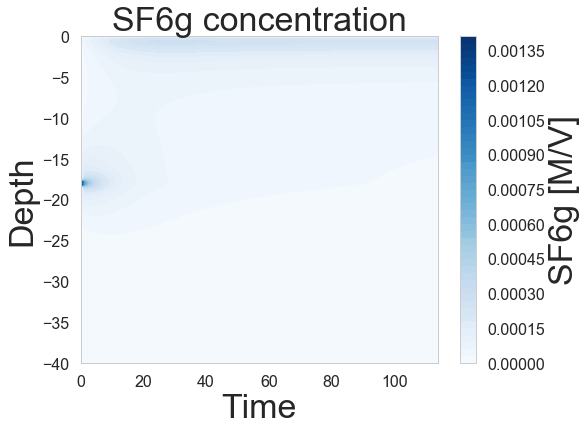

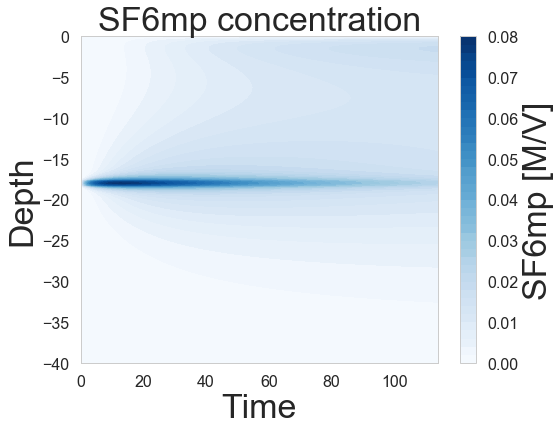

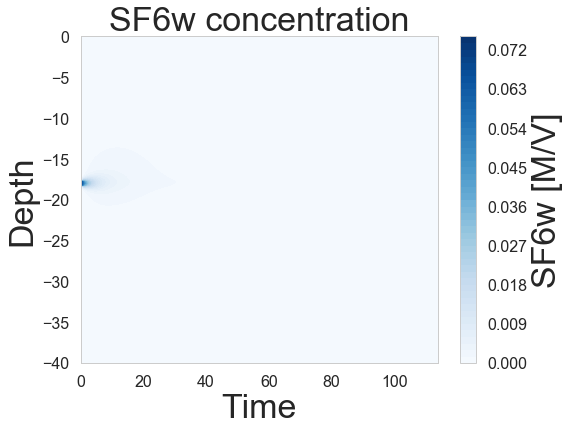

In [59]:
ftc1.plot_contourplots()

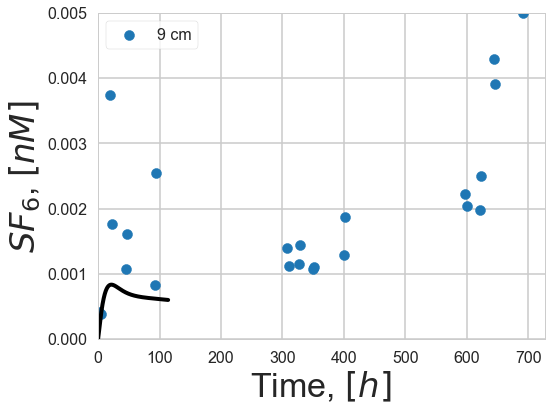

In [60]:
zm = 9
measured = (ftc1.SF6w.concentration[ftc1.x == zm, :][0] * phi_w[ftc1.x == zm] + ftc1.SF6g.concentration[ftc1.x == zm, :][0] * phi_g[ftc1.x == zm] ) / (phi_w[ftc1.x == zm] + phi_g[ftc1.x == zm])
# plt.scatter(Tm, C1D9, label='9 cm (C1)')
# plt.scatter(Tm, C2D9, label='9 cm (C2)')
# plt.scatter(Tm, C3D9, label='9 cm (C3)')
plt.scatter(Tm, (C1D9+C2D9+C3D9)/3, label='9 cm')
plt.plot(ftc1.time, measured, 'k-')
plt.ylabel(r'$SF_6$, $[nM]$')
plt.xlabel('Time, $[h]$')
plt.xlim(0,)
plt.ylim(0,0.005)
plt.legend(frameon=1, loc=2)


(0, 0.059754289379445658)

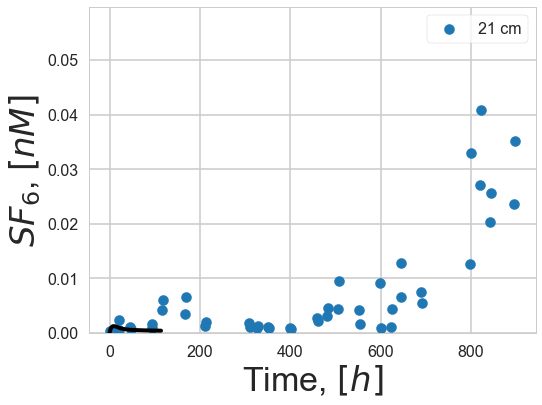

In [61]:
zm = 21
# plt.scatter(Tm, C1D21, label ='21 cm (C1)')
# plt.scatter(Tm, C2D21, label ='21 cm (C2)')
# plt.scatter(Tm, C3D21, label ='21 cm (C3)')
plt.scatter(Tm, (C1D21+C2D21+C3D21)/3, label='21 cm')
measured = (ftc1.SF6w.concentration[ftc1.x == zm, :][0] * phi_w[ftc1.x == zm] + ftc1.SF6g.concentration[ftc1.x == zm, :][0] * phi_g[ftc1.x == zm] ) / (phi_w[ftc1.x == zm] + phi_g[ftc1.x == zm])
plt.plot(ftc1.time, measured, 'k-')
plt.ylabel(r'$SF_6$, $[nM]$')
plt.xlabel('Time, $[h]$')
plt.legend(frameon=1)
# plt.xlim(0,)
plt.ylim(0,)

(0, 0.001)

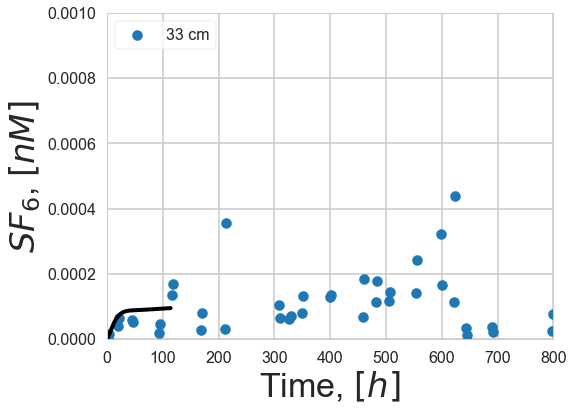

In [62]:
zm = 33
measured = (ftc1.SF6w.concentration[ftc1.x == zm, :][0] * phi_w[ftc1.x == zm] + ftc1.SF6g.concentration[ftc1.x == zm, :][0] * phi_g[ftc1.x == zm] ) / (phi_w[ftc1.x == zm] + phi_g[ftc1.x == zm])
# plt.scatter(Tm, C1D33, label='33 cm (C1)')
# plt.scatter(Tm, C2D33, label='33 cm (C2)')
# plt.scatter(Tm, C3D33, label='33 cm (C3)')
plt.scatter(Tm, (C1D33+C2D33+C3D33)/3, label='33 cm')
plt.plot(ftc1.time, measured, 'k-')
plt.ylabel(r'$SF_6$, $[nM]$')
plt.xlabel('Time, $[h]$')
plt.legend(frameon=1, loc=2)
plt.xlim(0,800)
plt.ylim(0, 0.001)

(0, 800)

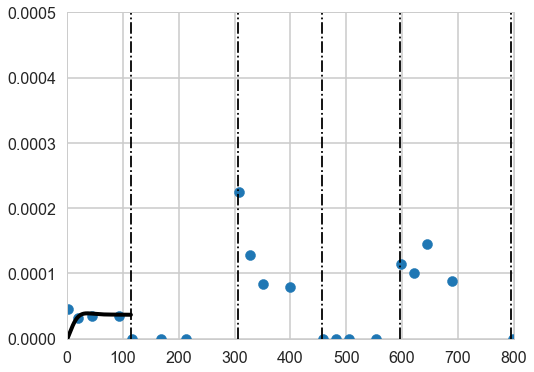

In [63]:
F1 = ftc1.estimate_flux_at_top('SF6g')
F2 = ftc1.estimate_flux_at_top('SF6w')
F3 = ftc1.estimate_flux_at_top('SF6mp')
# # gas flux

# plt.plot(ftc1.time, F1, 'g')
# plt.plot(ftc1.time, F2, 'b')
plt.plot(ftc1.time, F1+F2+F3, 'k')
# plt.plot(T_frz, [0] )
# F2 = ftc.estimate_flux_at_top('SF6w') # dissolved gas flux
# plt.plot(ftc.time, F2)


dC1h = (C1h[1::2] - C1h[::2])
# dC2h = (C2h[1::2] - C2h[::2])
# dC3h = (C3h[1::2] - C3h[::2])

plt.scatter(Tm[::2], dC1h*Vh1/SA/2)
# plt.scatter(Tm_1, dC2h*Vh2/SA/2)
# plt.scatter(Tm_1, dC3h*Vh3/SA/2)
for xc in periods:
    plt.axvline(x=xc, color='k', linewidth=1.8, linestyle='-.')
plt.ylim(0,0.0005)
plt.xlim(0,800)
# plt.scatter((Tm[::2]+1), dC1h*Vh1/SA/dT)


In [64]:
Ti_2 = Ti - periods[0]

In [65]:
periods

array([114, 306, 457, 596, 796, 944])

In [66]:
tend = periods[2] - periods[0]
dt = 0.01
dx = 0.2 ## cm
L = 40 ## cm
x = np.linspace(0, L, L / dx + 1)
t = np.linspace(0, tend, round(tend / dt) + 1)
#phi = 0.8
Chs = np.zeros(t.shape) #
Fx = np.zeros(t.shape)
phi = ( 0.99 - 0.91 ) * np.exp( -x / 10 ) + 0.91

/Users/imarkelo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """
/Users/imarkelo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  


In [67]:
ftc2 = Column(L, dx, tend, dt)

In [68]:
ftc2.add_species(theta=((phi_g**(10/3))/(phi**2)), element='SF6g', D= D_SF6g, init_C=ftc1.profiles.SF6g, bc_top=0, bc_top_type='constant', bc_bot=0, bc_bot_type='constant', w = -0.00)  #-0.055
ftc2.add_species(theta=((phi_w**(10/3))/(phi**2)), element='SF6w', D= D_SF6w, init_C=ftc1.profiles.SF6w, bc_top=0, bc_top_type='constant', bc_bot=0, bc_bot_type='constant', w = w)

# SF6mp stands for SF6 gas in micro pores, it is immobile and only collects SF6;
ftc2.add_species(theta=phi_p, element='SF6mp', D=1e-18, init_C=ftc1.profiles.SF6mp, bc_top=0, bc_top_type='flux', bc_bot=0, bc_bot_type='flux')


# # Constants
ftc2.constants['k_w_in'] =  k_w_in #from FTR w
ftc2.constants['k_w_out'] = k_w_out
#0.4

ftc2.constants['k_g_in'] = k_g_in
ftc2.constants['k_g_out'] = k_g_out

ftc2.constants['phi_w'] = phi_w
ftc2.constants['phi_g'] = phi_g
ftc2.constants['phi_p'] = phi_p


# # Rates of diffusion into pores and out
ftc2.rates['R_w_in'] = 'k_w_in * SF6w'
ftc2.rates['R_w_out'] = 'k_w_out * SF6mp'
# ftc2.rates['R_w_in'] = '0'
# ftc2.rates['R_w_out'] = '0'

ftc2.rates['R_g_in'] = 'k_g_in * SF6w'
ftc2.rates['R_g_out'] = 'k_g_out * SF6g'

# # dcdt
ftc2.dcdt['SF6w'] = '-R_g_in + R_g_out * phi_g - R_w_in + R_w_out * phi_p'
ftc2.dcdt['SF6g'] = 'R_g_in / phi_g - R_g_out'
ftc2.dcdt['SF6mp'] = 'R_w_in / phi_p - R_w_out'





In [69]:
for i in range(0, len(ftc2.time)):
    if (ftc2.time[i] + periods[0] > periods[0] and ftc2.time[i] + periods[0] < periods[1]) or (
            ftc2.time[i]+ periods[0] > periods[2] and ftc2.time[i] + periods[0] < periods[3]
    ) or (ftc2.time[i] + periods[0] > periods[4] and ftc2.time[i] + periods[0] < periods[5]):
        ftc2.change_boundary_conditions('SF6g', i, bc_top=0, bc_top_type='flux')
        ftc2.change_boundary_conditions('SF6w', i, bc_top=0, bc_top_type='flux')
        Fx[i] = 0
    else:
        ftc2.change_boundary_conditions('SF6g', i, bc_top=0, bc_top_type='constant')
        ftc2.change_boundary_conditions('SF6w', i, bc_top=0, bc_top_type='constant')
        F1 = ftc2.estimate_flux_at_top('SF6g', i)
        F2 = ftc2.estimate_flux_at_top('SF6w', i)
        F3 = ftc2.estimate_flux_at_top('SF6mp', i)
        Fx[i] = F1[i]+F2[i]+F3[i]
    if any([ftc2.time[i] == T_inj for T_inj in Ti_2]):
        SF6_add = np.zeros(x.size)
        SF6_add[x > 0] = 0
        SF6_add[x > 18 - (h_inj / 2)] = Ci[Ti_2 == ftc2.time[i]]
        SF6_add[x > 18 + (h_inj / 2)] = 0
        new_profile = ftc2.profiles['SF6w'] + SF6_add    #
        ftc2.change_concentration_profile('SF6w', i, new_profile)

    ftc2.integrate_one_timestep(i)

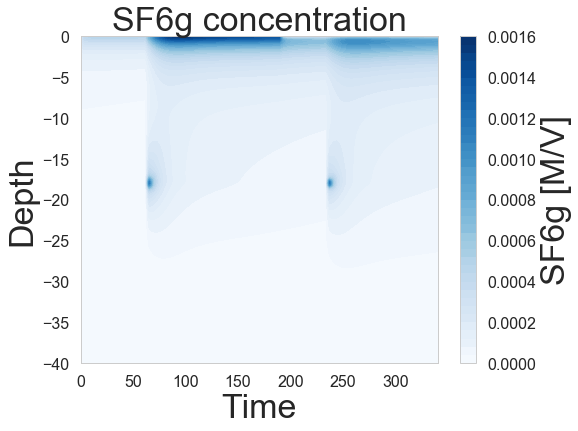

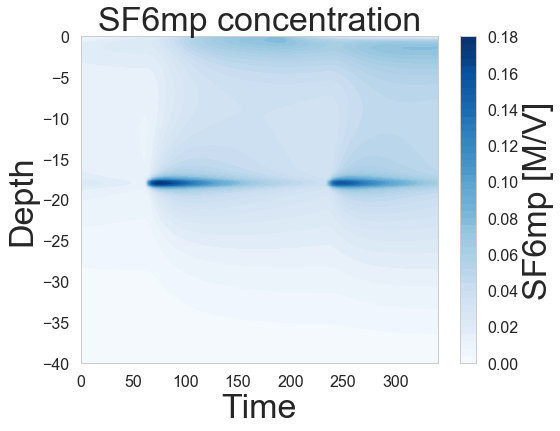

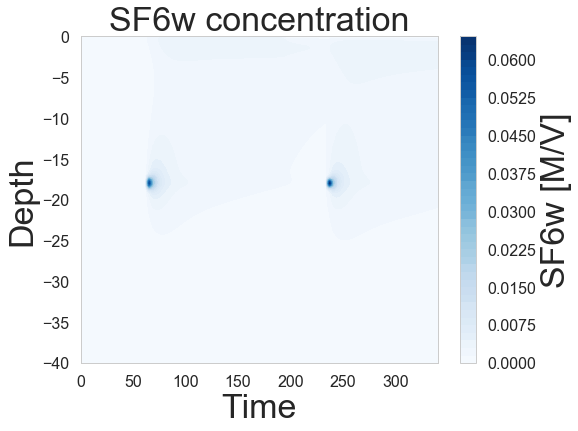

In [70]:
ftc2.plot_contourplots()

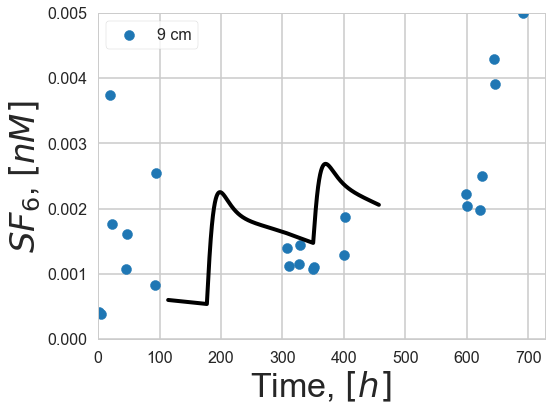

In [71]:
zm = 9
measured = (ftc2.SF6w.concentration[ftc2.x == zm, :][0] * phi_w[ftc2.x == zm] + ftc2.SF6g.concentration[ftc2.x == zm, :][0] * phi_g[ftc2.x == zm] ) / (phi_w[ftc2.x == zm] + phi_g[ftc2.x == zm])
# plt.scatter(Tm, C1D9, label='9 cm (C1)')
# plt.scatter(Tm, C2D9, label='9 cm (C2)')
# plt.scatter(Tm, C3D9, label='9 cm (C3)')
plt.scatter(Tm, (C1D9+C2D9+C3D9)/3, label='9 cm')
plt.plot(ftc2.time+periods[0], measured, 'k-')
plt.ylabel(r'$SF_6$, $[nM]$')
plt.xlabel('Time, $[h]$')
plt.xlim(0,)
plt.ylim(0,0.005)
plt.legend(frameon=1, loc=2)



(0, 0.059754289379445658)

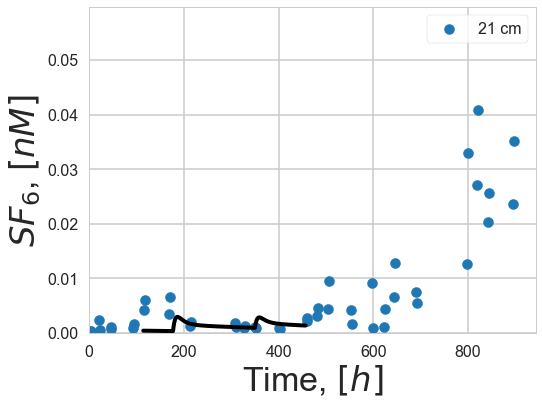

In [72]:
zm = 21
# plt.scatter(Tm, C1D21, label ='21 cm (C1)')
# plt.scatter(Tm, C2D21, label ='21 cm (C2)')
# plt.scatter(Tm, C3D21, label ='21 cm (C3)')
plt.scatter(Tm, (C1D21+C2D21+C3D21)/3, label='21 cm')
measured = (ftc2.SF6w.concentration[ftc2.x == zm, :][0] * phi_w[ftc2.x == zm] + ftc2.SF6g.concentration[ftc2.x == zm, :][0] * phi_g[ftc2.x == zm] ) / (phi_w[ftc2.x == zm] + phi_g[ftc2.x == zm])
plt.plot(ftc2.time+periods[0], measured, 'k-')
plt.ylabel(r'$SF_6$, $[nM]$')
plt.xlabel('Time, $[h]$')
plt.legend(frameon=1)
plt.xlim(0,)
plt.ylim(0,)

(0, 0.001)

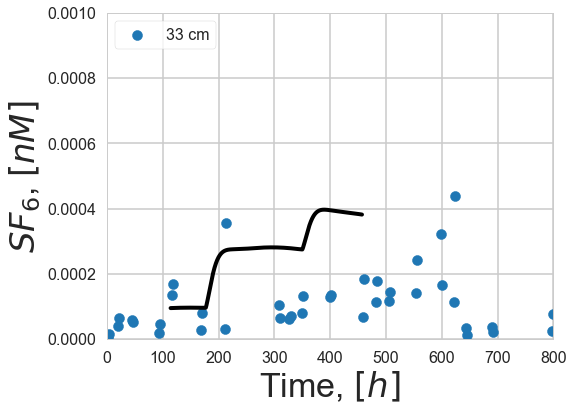

In [73]:
zm = 33
measured = (ftc2.SF6w.concentration[ftc2.x == zm, :][0] * phi_w[ftc2.x == zm] + ftc2.SF6g.concentration[ftc2.x == zm, :][0] * phi_g[ftc2.x == zm] ) / (phi_w[ftc2.x == zm] + phi_g[ftc2.x == zm])
# plt.scatter(Tm, C1D33, label='33 cm (C1)')
# plt.scatter(Tm, C2D33, label='33 cm (C2)')
# plt.scatter(Tm, C3D33, label='33 cm (C3)')
plt.scatter(Tm, (C1D33+C2D33+C3D33)/3, label='33 cm')
plt.plot(ftc2.time+periods[0], measured, 'k-')
plt.ylabel(r'$SF_6$, $[nM]$')
plt.xlabel('Time, $[h]$')
plt.legend(frameon=1, loc=2)
plt.xlim(0,800)
plt.ylim(0, 0.001)

(0, 800)

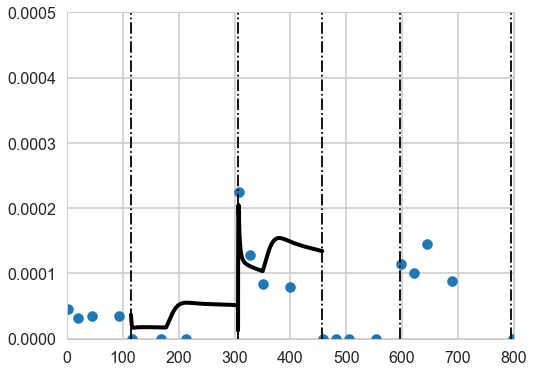

In [74]:
F1 = ftc2.estimate_flux_at_top('SF6g')
F2 = ftc2.estimate_flux_at_top('SF6w')
F3 = ftc2.estimate_flux_at_top('SF6mp')
# # gas flux

# plt.plot(ftc1.time, F1, 'g')
# plt.plot(ftc1.time, F2, 'b')
plt.plot(ftc2.time+periods[0], F1+F2+F3, 'k')
# plt.plot(T_frz, [0] )
# F2 = ftc.estimate_flux_at_top('SF6w') # dissolved gas flux
# plt.plot(ftc.time, F2)


dC1h = (C1h[1::2] - C1h[::2])
# dC2h = (C2h[1::2] - C2h[::2])
# dC3h = (C3h[1::2] - C3h[::2])

plt.scatter(Tm[::2], dC1h*Vh1/SA/2)
# plt.scatter(Tm, dC2h*Vh2/SA/2)
# plt.scatter(Tm, dC3h*Vh3/SA/2)
for xc in periods:
    plt.axvline(x=xc, color='k', linewidth=1.8, linestyle='-.')
plt.ylim(0,0.0005)
plt.xlim(0,800)
# plt.scatter((Tm[::2]+1), dC1h*Vh1/SA/dT)



In [75]:
periods

array([114, 306, 457, 596, 796, 944])

In [76]:
Ti_3 = Ti - periods[2]

In [77]:
tend = periods[4] - periods[2]
dt = 0.01
dx = 0.2 ## cm
L = 40 ## cm
x = np.linspace(0, L, L / dx + 1)
t = np.linspace(0, tend, round(tend / dt) + 1)
#phi = 0.8
Chs = np.zeros(t.shape) #
Fx = np.zeros(t.shape)
phi = ( 0.99 - 0.91 ) * np.exp( -x / 10 ) + 0.91

/Users/imarkelo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """
/Users/imarkelo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  


In [78]:
ftc3 = Column(L, dx, tend, dt)

In [79]:
ftc3.add_species(theta=((phi_g**(10/3))/(phi**2)), element='SF6g', D= D_SF6g, init_C=ftc2.profiles.SF6g, bc_top=0, bc_top_type='constant', bc_bot=0, bc_bot_type='constant', w = -0.00)  #-0.055
ftc3.add_species(theta=((phi_w**(10/3))/(phi**2)), element='SF6w', D= D_SF6w, init_C=ftc2.profiles.SF6w, bc_top=0, bc_top_type='constant', bc_bot=0, bc_bot_type='constant', w = w)

# SF6mp stands for SF6 gas in micro pores, it is immobile and only collects SF6;
ftc3.add_species(theta=phi_p, element='SF6mp', D=1e-18, init_C=ftc2.profiles.SF6mp, bc_top=0, bc_top_type='flux', bc_bot=0, bc_bot_type='flux')


# # Constants
ftc3.constants['k_w_in'] =  k_w_in #from FTR w
ftc3.constants['k_w_out'] = k_w_out
#0.4

ftc3.constants['k_g_in'] = k_g_in
ftc3.constants['k_g_out'] = k_g_out

ftc3.constants['phi_w'] = phi_w
ftc3.constants['phi_g'] = phi_g
ftc3.constants['phi_p'] = phi_p


# # Rates of diffusion into pores and out
ftc3.rates['R_w_in'] = 'k_w_in * SF6w'
ftc3.rates['R_w_out'] = 'k_w_out * SF6mp'
# ftc3.rates['R_w_in'] = '0'
# ftc3.rates['R_w_out'] = '0'

ftc3.rates['R_g_in'] = 'k_g_in * SF6w'
ftc3.rates['R_g_out'] = 'k_g_out * SF6g'

# # dcdt
ftc3.dcdt['SF6w'] = '-R_g_in + R_g_out * phi_g - R_w_in + R_w_out * phi_p'
ftc3.dcdt['SF6g'] = 'R_g_in / phi_g - R_g_out'
ftc3.dcdt['SF6mp'] = 'R_w_in / phi_p - R_w_out'






In [80]:
for i in range(0, len(ftc3.time)):
    if (ftc3.time[i] + periods[2] > periods[0] and ftc3.time[i] + periods[2] < periods[1]) or (
            ftc3.time[i]+ periods[2] > periods[2] and ftc3.time[i] + periods[2] < periods[3]
    ) or (ftc3.time[i] + periods[2] > periods[4] and ftc3.time[i] + periods[2] < periods[5]):
        ftc3.change_boundary_conditions('SF6g', i, bc_top=0, bc_top_type='flux')
        ftc3.change_boundary_conditions('SF6w', i, bc_top=0, bc_top_type='flux')
        Fx[i] = 0
    else:
        ftc3.change_boundary_conditions('SF6g', i, bc_top=0, bc_top_type='constant')
        ftc3.change_boundary_conditions('SF6w', i, bc_top=0, bc_top_type='constant')
        F1 = ftc3.estimate_flux_at_top('SF6g', i)
        F2 = ftc3.estimate_flux_at_top('SF6w', i)
        F3 = ftc3.estimate_flux_at_top('SF6mp', i)
        Fx[i] = F1[i]+F2[i]+F3[i]
    if any([ftc3.time[i] == T_inj for T_inj in Ti_3]):
        SF6_add = np.zeros(x.size)
        SF6_add[x > 0] = 0
        SF6_add[x > 18 - (h_inj / 2)] = Ci[Ti_3 == ftc3.time[i]]
        SF6_add[x > 18 + (h_inj / 2)] = 0
        new_profile = ftc3.profiles['SF6w'] + SF6_add    #
        ftc3.change_concentration_profile('SF6w', i, new_profile)

    ftc3.integrate_one_timestep(i)

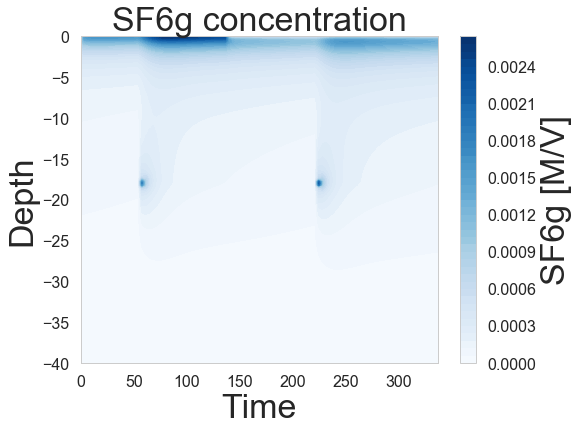

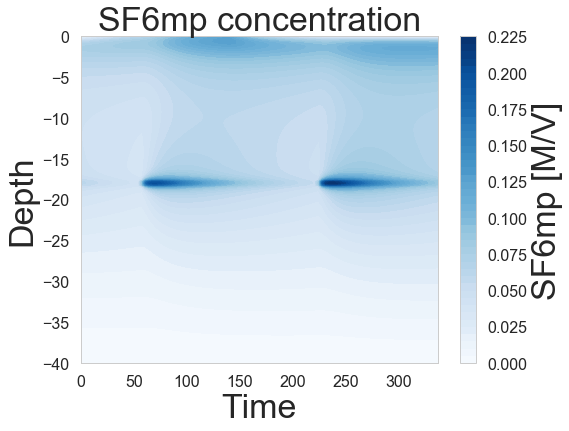

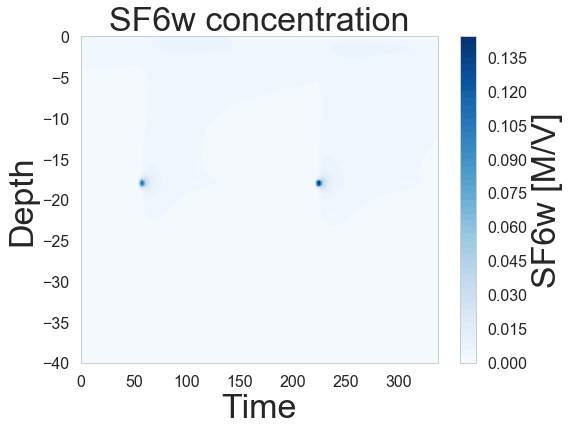

In [81]:
ftc3.plot_contourplots()

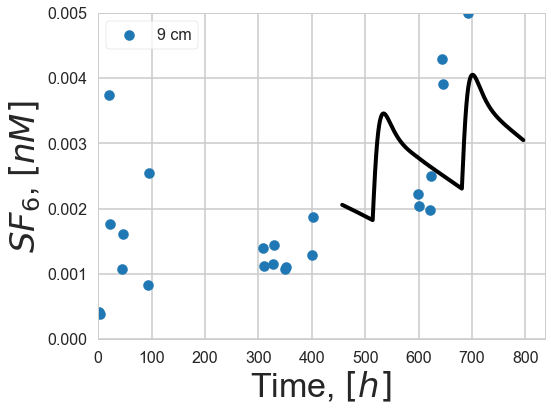

In [82]:
zm = 9
measured = (ftc3.SF6w.concentration[ftc3.x == zm, :][0] * phi_w[ftc3.x == zm] + ftc3.SF6g.concentration[ftc3.x == zm, :][0] * phi_g[ftc3.x == zm] ) / (phi_w[ftc3.x == zm] + phi_g[ftc3.x == zm])
# plt.scatter(Tm, C1D9, label='9 cm (C1)')
# plt.scatter(Tm, C2D9, label='9 cm (C2)')
# plt.scatter(Tm, C3D9, label='9 cm (C3)')
plt.scatter(Tm, (C1D9+C2D9+C3D9)/3, label='9 cm')
plt.plot(ftc3.time+periods[2], measured, 'k-')
plt.ylabel(r'$SF_6$, $[nM]$')
plt.xlabel('Time, $[h]$')
plt.xlim(0,)
plt.ylim(0,0.005)
plt.legend(frameon=1, loc=2)




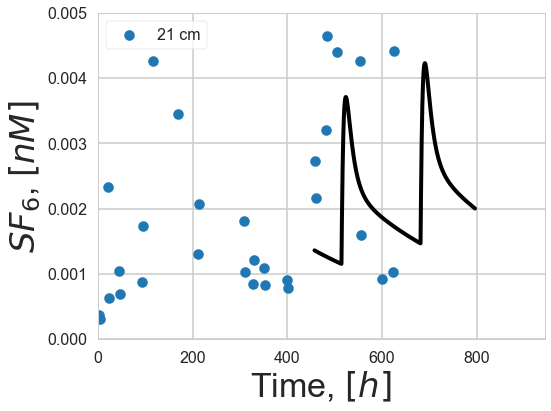

In [83]:
zm = 21
measured = (ftc3.SF6w.concentration[ftc3.x == zm, :][0] * phi_w[ftc3.x == zm] + ftc3.SF6g.concentration[ftc3.x == zm, :][0] * phi_g[ftc3.x == zm] ) / (phi_w[ftc3.x == zm] + phi_g[ftc3.x == zm])
# plt.scatter(Tm, C1D9, label='9 cm (C1)')
# plt.scatter(Tm, C2D9, label='9 cm (C2)')
# plt.scatter(Tm, C3D9, label='9 cm (C3)')
plt.scatter(Tm, (C1D21+C2D21+C3D21)/3, label='21 cm')
plt.plot(ftc3.time+periods[2], measured, 'k-')
plt.ylabel(r'$SF_6$, $[nM]$')
plt.xlabel('Time, $[h]$')
plt.xlim(0,)
plt.ylim(0,0.005)
plt.legend(frameon=1, loc=2)




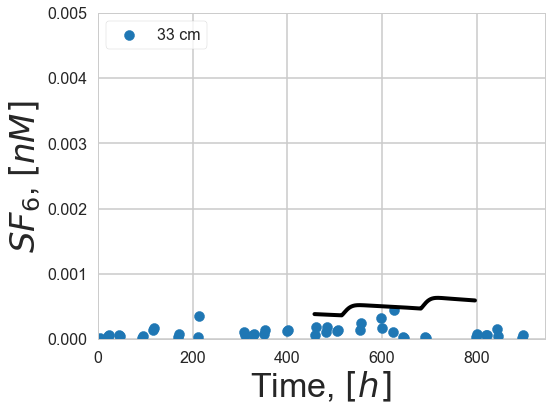

In [84]:
zm = 33
measured = (ftc3.SF6w.concentration[ftc3.x == zm, :][0] * phi_w[ftc3.x == zm] + ftc3.SF6g.concentration[ftc3.x == zm, :][0] * phi_g[ftc3.x == zm] ) / (phi_w[ftc3.x == zm] + phi_g[ftc3.x == zm])
# plt.scatter(Tm, C1D9, label='9 cm (C1)')
# plt.scatter(Tm, C2D9, label='9 cm (C2)')
# plt.scatter(Tm, C3D9, label='9 cm (C3)')
plt.scatter(Tm, (C1D33+C2D33+C3D33)/3, label='33 cm')
plt.plot(ftc3.time+periods[2], measured, 'k-')
plt.ylabel(r'$SF_6$, $[nM]$')
plt.xlabel('Time, $[h]$')
plt.xlim(0,)
plt.ylim(0,0.005)
plt.legend(frameon=1, loc=2)





(0, 800)

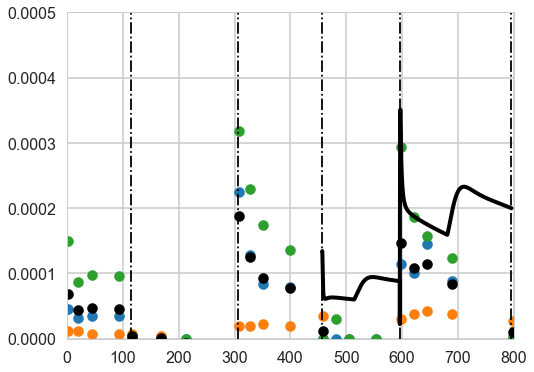

In [85]:
F1 = ftc3.estimate_flux_at_top('SF6g')
F2 = ftc3.estimate_flux_at_top('SF6w')
F3 = ftc3.estimate_flux_at_top('SF6mp')
# # gas flux

# plt.plot(ftc1.time, F1, 'g')
# plt.plot(ftc1.time, F2, 'b')
plt.plot(ftc3.time+periods[2], F1+F2+F3, 'k')
# plt.plot(T_frz, [0] )
# F2 = ftc.estimate_flux_at_top('SF6w') # dissolved gas flux
# plt.plot(ftc.time, F2)


dC1h = (C1h[1::2] - C1h[::2])
dC2h = (C2h[1::2] - C2h[::2])
dC3h = (C3h[1::2] - C3h[::2])

plt.scatter(Tm[::2], dC1h*Vh1/SA/2)
plt.scatter(Tm[::2], dC2h*Vh2/SA/2)
plt.scatter(Tm[::2], dC3h*Vh3/SA/2)
plt.scatter(Tm[::2], (dC3h*Vh3/SA/2 + dC2h*Vh2/SA/2 + dC1h*Vh1/SA/2)/3, c='k')
for xc in periods:
    plt.axvline(x=xc, color='k', linewidth=1.8, linestyle='-.')
plt.ylim(0,0.0005)
plt.xlim(0,800)
# plt.scatter((Tm[::2]+1), dC1h*Vh1/SA/dT)




In [86]:
from porousmedialab.calibrator import find_indexes_of_intersections

In [87]:

zm = 9
M1D9 = (
    ftc1.SF6w.concentration[ftc1.x == zm, :] *
    phi_w[ftc1.x == zm] + ftc1.SF6g.
    concentration[ftc1.x == zm, :] * phi_g[ftc1.x == zm]) / (
        phi_w[ftc1.x == zm] + phi_g[ftc1.x == zm])

M2D9 = (
    ftc2.SF6w.concentration[ftc2.x == zm, :] *
    phi_w[ftc2.x == zm] + ftc2.SF6g.
    concentration[ftc2.x == zm, :] * phi_g[ftc2.x == zm]) / (
        phi_w[ftc2.x == zm] + phi_g[ftc2.x == zm])

M3D9 = (
    ftc3.SF6w.concentration[ftc3.x == zm, :] *
    phi_w[ftc3.x == zm] + ftc3.SF6g.
    concentration[ftc3.x == zm, :] * phi_g[ftc3.x == zm]) / (
        phi_w[ftc3.x == zm] + phi_g[ftc3.x == zm])

MD9 = np.concatenate((M1D9[0], M2D9[0], M3D9[0]))

zm = 21
M1D21 = (
    ftc1.SF6w.concentration[ftc1.x == zm, :] *
    phi_w[ftc1.x == zm] + ftc1.SF6g.
    concentration[ftc1.x == zm, :] * phi_g[ftc1.x == zm]) / (
        phi_w[ftc1.x == zm] + phi_g[ftc1.x == zm])

M2D21 = (
    ftc2.SF6w.concentration[ftc2.x == zm, :] *
    phi_w[ftc2.x == zm] + ftc2.SF6g.
    concentration[ftc2.x == zm, :] * phi_g[ftc2.x == zm]) / (
        phi_w[ftc2.x == zm] + phi_g[ftc2.x == zm])

M3D21 = (
    ftc3.SF6w.concentration[ftc3.x == zm, :] *
    phi_w[ftc3.x == zm] + ftc3.SF6g.
    concentration[ftc3.x == zm, :] * phi_g[ftc3.x == zm]) / (
        phi_w[ftc3.x == zm] + phi_g[ftc3.x == zm])

MD21 = np.concatenate((M1D21[0], M2D21[0], M3D21[0]))

zm = 33
M1D33 = (
    ftc1.SF6w.concentration[ftc1.x == zm, :] *
    phi_w[ftc1.x == zm] + ftc1.SF6g.
    concentration[ftc1.x == zm, :] * phi_g[ftc1.x == zm]) / (
        phi_w[ftc1.x == zm] + phi_g[ftc1.x == zm])

M2D33 = (
    ftc2.SF6w.concentration[ftc2.x == zm, :] *
    phi_w[ftc2.x == zm] + ftc2.SF6g.
    concentration[ftc2.x == zm, :] * phi_g[ftc2.x == zm]) / (
        phi_w[ftc2.x == zm] + phi_g[ftc2.x == zm])

M3D33 = (
    ftc3.SF6w.concentration[ftc3.x == zm, :] *
    phi_w[ftc3.x == zm] + ftc3.SF6g.
    concentration[ftc3.x == zm, :] * phi_g[ftc3.x == zm]) / (
        phi_w[ftc3.x == zm] + phi_g[ftc3.x == zm])

MD33 = np.concatenate((M1D33[0], M2D33[0], M3D33[0]))


MF1 = ftc1.estimate_flux_at_top('SF6g') + ftc1.estimate_flux_at_top('SF6w') + ftc1.estimate_flux_at_top('SF6mp')
MF2 = ftc2.estimate_flux_at_top('SF6g') + ftc2.estimate_flux_at_top('SF6w') + ftc2.estimate_flux_at_top('SF6mp')
MF3 = ftc3.estimate_flux_at_top('SF6g') + ftc3.estimate_flux_at_top('SF6w') + ftc3.estimate_flux_at_top('SF6mp')

MF = np.concatenate((MF1, MF2, MF3))

MT = np.concatenate((ftc1.time, ftc2.time + ftc1.time[-1], ftc3.time + ftc2.time[-1] + ftc1.time[-1]))


(0, 0.006)

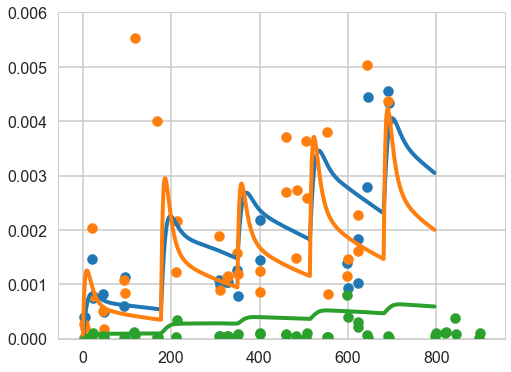

In [93]:
plt.plot(MT, MD9)
plt.scatter(Tm, C1D9)
plt.plot(MT, MD21)
plt.scatter(Tm, C1D21)
plt.plot(MT, MD33)
plt.scatter(Tm, C1D33)
# plt.xlim(0,796)
plt.ylim(0,0.006)

In [89]:
idxs = find_indexes_of_intersections(MT, Tm)

In [90]:
rmse(MD9[idxs], C1D9[:len(MD21[idxs])])

NameError: name 'rmse' is not defined

In [ ]:
C1D9[:2]

In [ ]:
from porousmedialab.metrics import rmse

In [ ]:
dC1h = (C1h[1::2] - C1h[::2])
dC2h = (C2h[1::2] - C2h[::2])
dC3h = (C3h[1::2] - C3h[::2])
Fx_mean = (dC3h * Vh3 / SA / 2 + dC2h * Vh2 / SA / 2 + dC1h * Vh1 / SA / 2) / 3

CD33_mean = (C1D33 + C2D33 + C3D33) / 3
CD21_mean = (C1D21 + C2D21 + C3D21) / 3
CD9_mean = (C1D9 + C2D9 + C3D9) / 3

In [ ]:
err = rmse(MD9[idxs], CD9_mean[:len(MD9[idxs])]) + rmse(
    MD21[idxs], CD21_mean[:len(MD21[idxs])]) + rmse(MD33[idxs],
                                              CD33_mean[:len(MD33[idxs])]) + 100 * rmse(MF[idxs_f], Fx_mean[:len(MF[idxs_f])])

In [ ]:
err

In [ ]:
idxs_f = find_indexes_of_intersections(MT, Tm[::2]+1)

In [ ]:
rmse(MF[idxs_f], Fx_mean[:len(MF[idxs_f])])

In [ ]:
err = rmse(MD9[idxs], CD9_mean[:len(MD9[idxs])]) + rmse(
    MD21[idxs], CD21_mean[:len(MD21[idxs])]) + rmse(MD33[idxs],
                                              CD33_mean[:len(MD33[idxs])]) + 100 * rmse(MF[idxs_f], Fx_mean[:len(MF[idxs_f])])

In [ ]:
err

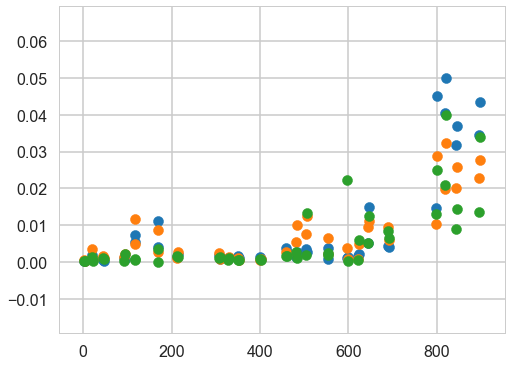

In [96]:
plt.scatter(Tm, C1D21)
plt.scatter(Tm, C2D21)
plt.scatter(Tm, C3D21)